<a href="https://colab.research.google.com/github/YandaAzizHusein/apple-quality-classification/blob/main/apple_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import Library

In [23]:
import kagglehub
import os

import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline & Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Evaluasi
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#persiapan dataset

In [24]:
# Download dataset
path = kagglehub.dataset_download("nelgiriyewithana/apple-quality")
print("Path to dataset files:", path)

# Cek isi folder untuk tahu nama file
print(os.listdir(path))

# Load CSV (ganti nama file sesuai hasil os.listdir, biasanya 'apple_quality.csv')
df = pd.read_csv(os.path.join(path, "apple_quality.csv"))

Using Colab cache for faster access to the 'apple-quality' dataset.
Path to dataset files: /kaggle/input/apple-quality
['apple_quality.csv']


#EDA

In [25]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [26]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


In [27]:
df.isnull().sum()

,0
A_id,1
Size,1
Weight,1
Sweetness,1
Crunchiness,1
Juiciness,1
Ripeness,1
Acidity,0
Quality,1


In [28]:
df.duplicated().sum()

np.int64(0)

In [29]:
df['Quality'].value_counts()

,count
Quality,
good,2004
bad,1996


In [30]:
# Mapping ke numerik
df['Quality_num'] = df['Quality'].map({'good': 1, 'bad': 0})

# ubah kolom acidity jadi numeric
df['Acidity'] = pd.to_numeric(df['Acidity'], errors='coerce')


# Cek hasil
print(df['Quality'].unique())
print(df['Quality_num'].value_counts())

['good' 'bad' nan]
Quality_num
1.0    2004
0.0    1996
Name: count, dtype: int64


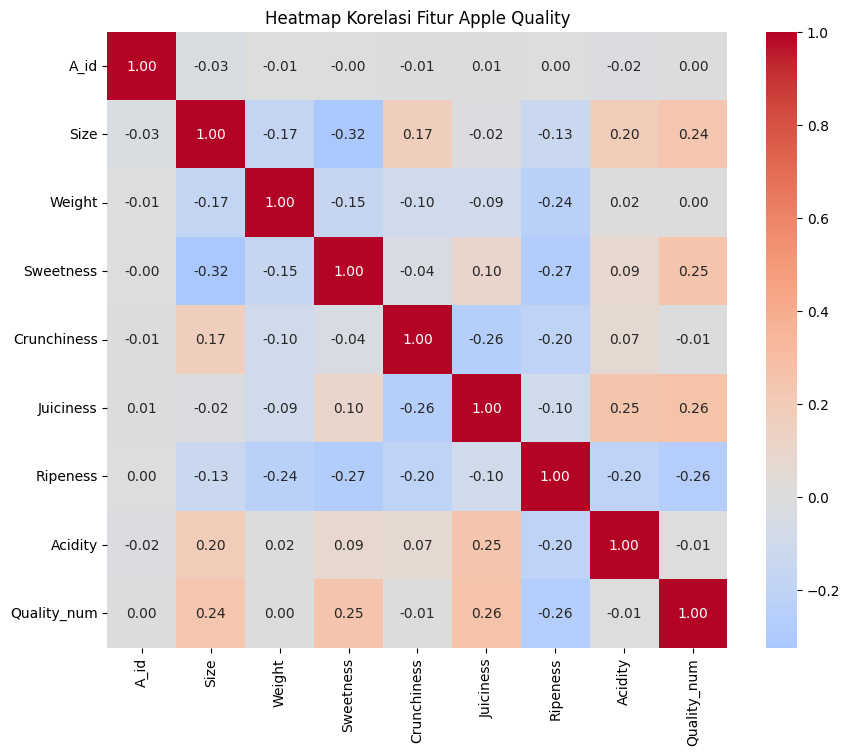

In [31]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Heatmap Korelasi Fitur Apple Quality")
plt.show()


insight awalnya : yang penting size, sweetness, juicesness, dan ripenss

###Preparation

In [32]:
df

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality,Quality_num
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good,1.0
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good,1.0
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad,0.0
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good,1.0
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good,1.0
...,...,...,...,...,...,...,...,...,...,...
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,good,1.0
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,bad,0.0
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229720,good,1.0
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796,good,1.0


In [33]:
df.drop(['Quality', #dihapus karena target yang masih string karena sudah dibuat jadi numerik
         'A_id', #tidak berkorelasi
         'Weight', #tidak berkorelasi
         'Crunchiness' #tidak berkorelasi
         ], axis=1, inplace=True)

df = df.drop(df.index[-1]) #Hapus baris terakhir

df = df.dropna()  # drop semua kolom NaN

In [34]:
df

,Size,Sweetness,Juiciness,Ripeness,Acidity,Quality_num
0,-3.970049,5.346330,1.844900,0.329840,-0.491590,1.0
1,-1.195217,3.664059,0.853286,0.867530,-0.722809,1.0
2,-0.292024,-1.738429,2.838636,-0.038033,2.621636,0.0
3,-0.657196,1.324874,3.637970,-3.413761,0.790723,1.0
4,1.364217,-0.384658,3.030874,-1.303849,0.501984,1.0
...,...,...,...,...,...,...
3995,0.059386,-3.714549,1.697986,2.244055,0.137784,0.0
3996,-0.293118,-0.204020,0.024523,-1.087900,1.854235,1.0
3997,-2.634515,-2.440461,2.199709,4.763859,-1.334611,0.0
3998,-4.008004,2.366397,2.161435,0.214488,-2.229720,1.0


In [35]:
# --- Pisahkan fitur & target ---
X = df.drop(columns=['Quality', 'Quality_num'], errors='ignore')
y = df['Quality_num']

# --- Split data (80% train, 20% test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test  shape:", X_test.shape,  y_test.shape)

Train shape: (3200, 5) (3200,)
Test  shape: (800, 5) (800,)


###Modelling

In [53]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(f"Akurasi: {accuracy_score(y_true, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')



=== Logistic Regression ===
Akurasi: 0.7275
Classification Report:
              precision    recall  f1-score   support

         0.0     0.7280    0.7243    0.7261       399
         1.0     0.7270    0.7307    0.7289       401

    accuracy                         0.7275       800
   macro avg     0.7275    0.7275    0.7275       800
weighted avg     0.7275    0.7275    0.7275       800



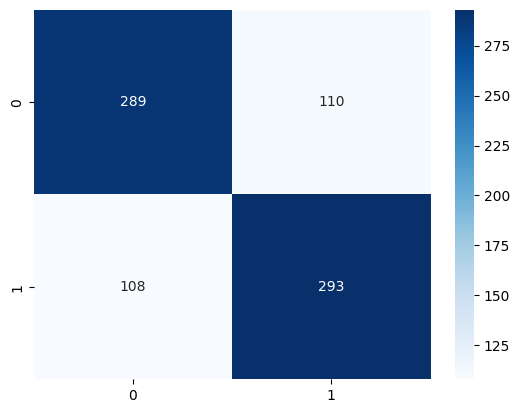

In [54]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
evaluate_model("Logistic Regression", y_test, y_pred_logreg)


=== Random Forest ===
Akurasi: 0.8337
Classification Report:
              precision    recall  f1-score   support

         0.0     0.8500    0.8095    0.8293       399
         1.0     0.8190    0.8579    0.8380       401

    accuracy                         0.8337       800
   macro avg     0.8345    0.8337    0.8336       800
weighted avg     0.8345    0.8337    0.8336       800



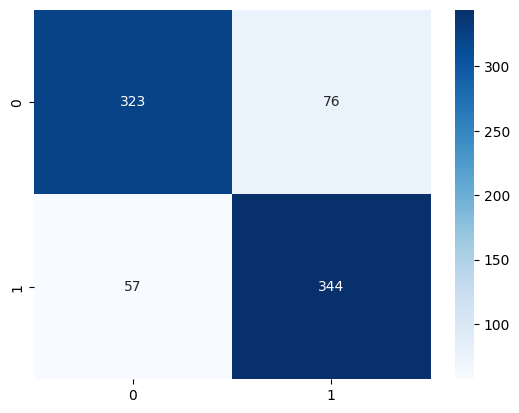

In [55]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate_model("Random Forest", y_test, y_pred_rf)


=== XGBoost ===
Akurasi: 0.8263
Classification Report:
              precision    recall  f1-score   support

         0.0     0.8421    0.8020    0.8216       399
         1.0     0.8119    0.8504    0.8307       401

    accuracy                         0.8263       800
   macro avg     0.8270    0.8262    0.8261       800
weighted avg     0.8270    0.8263    0.8261       800



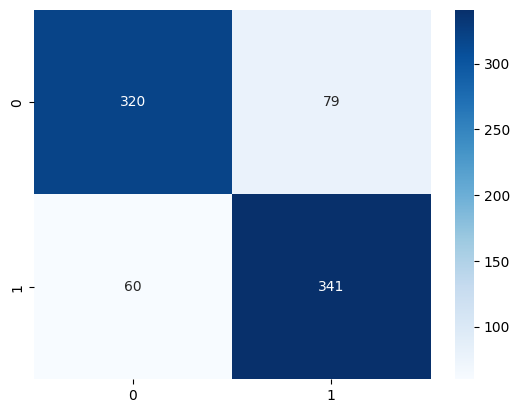

In [56]:
# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_model("XGBoost", y_test, y_pred_xgb)